<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras Hub starter guide here: https://keras.io/keras_hub/getting_started/

__This starter notebook uses the [BERT](https://arxiv.org/abs/1810.04805) pretrained model from KerasNLP.__

**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


![BERT Architecture](http://miro.medium.com/v2/resize:fit:1032/0*x3vhaoJdGndvZqmL.png)


This notebook contains complete code to fine-tune BERT to perform a **Natural Language Inferencing (NLI)** model. NLI is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

Our **NLI model** will assign labels of 0, 1, or 2 (corresponding to **entailment, neutral, and contradiction**) to pairs of premises and hypotheses.

Note that the train and test set include text in **fifteen different languages**!


In this notebook, you will:

- Load the Contradictory, My Dear Watson dataset
- Explore the dataset
- Preprocess the data
- Load a BERT model from Keras NLP
- Train your own model, fine-tuning BERT as part of that


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import keras_hub
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasHub version:", keras_hub.__version__)

TensorFlow version: 2.16.2
Keras version: 3.9.2
KerasHub version: 0.20.0


# Accelerator

Detect hardware, return appropriate distribution strategy

In [2]:
 try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # instantiate a distribution strategy
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not activated")
    strategy = tf.distribute.MirroredStrategy() # Works on CPU, single GPU and multiple GPUs in a single VM.
    
print("replicas:", strategy.num_replicas_in_sync)

TPU not activated
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
replicas: 1


2025-04-15 12:15:23.543165: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-04-15 12:15:23.543188: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-15 12:15:23.543197: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-15 12:15:23.543214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-15 12:15:23.543225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Load the Contradictory, My Dear Watson dataset

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

In [3]:
RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

In [4]:
df_watson = pd.read_csv("data.csv")
df_watson.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Let's look at some pairs of sentences.

In [5]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

df_watson[7:10].head().apply(lambda x : display_pair_of_sentence(x), axis=1)

df_watson.shape

Premise : From Cockpit Country to St. Ann's Bay
Hypothesis: From St. Ann's Bay to Cockpit Country.
Language: English
Label: 2

Premise : Look, it's your skin, but you're going to be in trouble if you don't get busy.
Hypothesis: The boss will fire you if he sees you slacking off.
Language: English
Label: 1

Premise : Через каждые сто градусов пятна краски меняют свой цвет, она может быть красной и изменить цвет на синий.
Hypothesis: Краска изменяется в соответствии с цветом.
Language: Russian
Label: 0



(12120, 6)

# Explore the dataset

Let's look at the distribution of labels in the training set.

/var/folders/6z/j6f33tds3v7dv8tryfqnxf5m0000gn/T/ipykernel_98724/1018596222.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])


Text(0.5, 1.0, 'Distribution of labels in the training set')

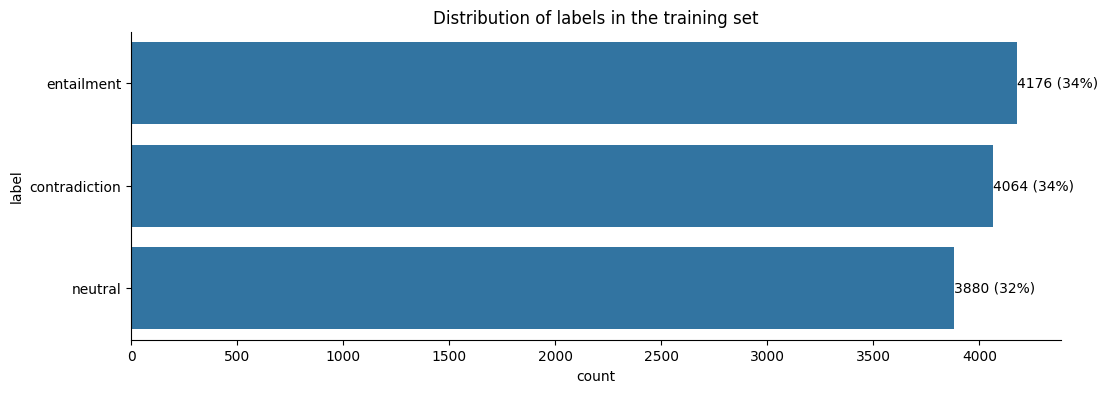

In [6]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_watson, 
                   y="label",
                   order = df_watson['label'].value_counts().index)

abs_values = df_watson['label'].value_counts(ascending=False)
rel_values = df_watson['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Let's look at the distribution of languages in the training set.

Text(0.5, 1.0, 'Distribution of languages in the training set')

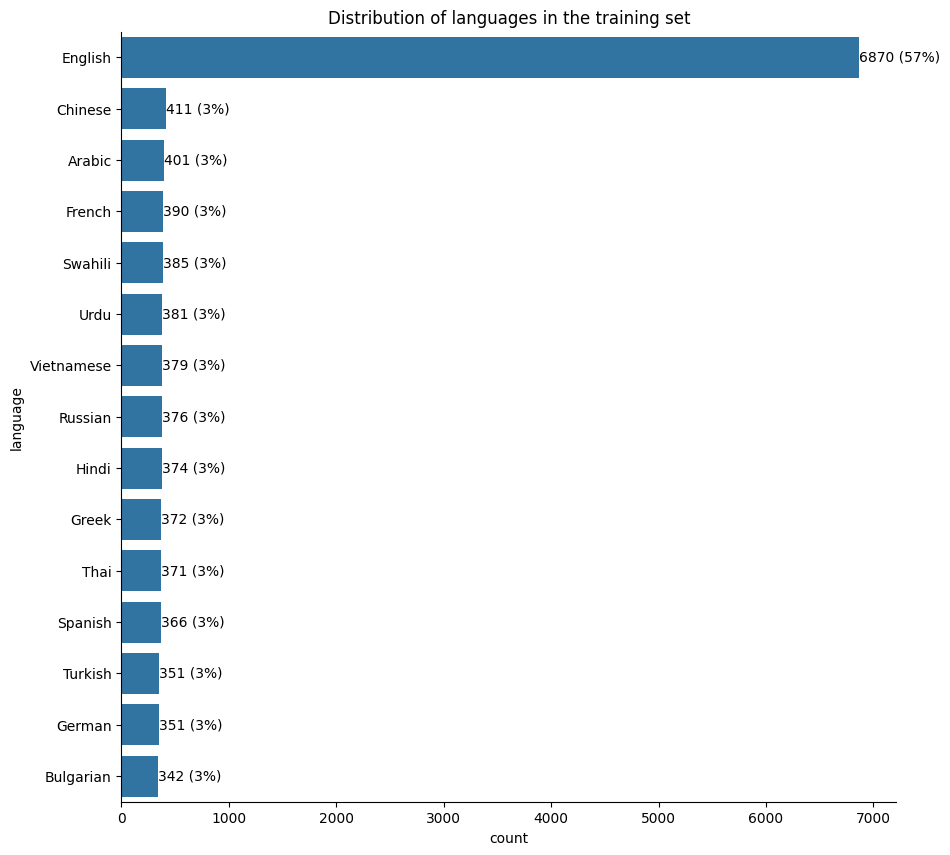

In [7]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_watson, 
                   y="language",
                   order = df_watson['language'].value_counts().index)

abs_values = df_watson['language'].value_counts(ascending=False)
rel_values = df_watson['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

Let's look at the length of the sentences

In [8]:
df_watson["premise_length"] = df_watson["premise"].apply(lambda x : len(x))
df_watson["hypothesis_length"] = df_watson["hypothesis"].apply(lambda x : len(x))
df_watson[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,53.892327,107.373185
std,25.302358,71.089954
min,4.000000,4.000000
25%,36.000000,55.000000
50%,51.000000,96.000000
75%,67.000000,146.000000
max,276.000000,967.000000


# Preprocess the data

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can  be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

Bert is only trained in English corpus. That's why people use multilingual Bert or XLM-Roberta for this competition.

Here are some models for multi-language NLP available in Keras NLP:
- bert_base_multi
- deberta_v3_base_multi
- distil_bert_base_multi
- xlm_roberta_base_multi
- xlm_roberta_large_multi


In [9]:
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_watson.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


Here's a utility function that splits the example into an `(x, y)` tuple that is suitable for `model.fit()`.

By default, `keras_nlp.models.BertClassifier` will tokenize and pack together raw strings using a `"[SEP]"` token during training.

Therefore, this label splitting is all the data preparation that we need to perform.

In [10]:
def split_labels(x, y):
    return (x[0], x[1]), y


watson_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_watson[['premise','hypothesis']].values, keras.utils.to_categorical(df_watson['label'], num_classes=3)
        )
    )
)

train_dataset = watson_dataset.take(TRAIN_SIZE)
val_dataset = watson_dataset.skip(TRAIN_SIZE)

# Apply the preprocessor to every sample of train, val and test data using `map()`.
# [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data/AUTOTUNE) and `prefetch()` are options to tune performance, see
# https://www.tensorflow.org/guide/data_performance for details.

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

# Load a BERT model from Keras NLP - Train the model

In [11]:
# Load a BERT model.
# The model is downloaded automatically from TensorFlow Hub.
with strategy.scope():
    classifier = keras_hub.models.BertClassifier.from_preset("bert_base_multi", num_classes=3)

    # in distributed training, the recommendation is to scale batch size and learning rate with the numer of workers.
    classifier.compile(optimizer=keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync),
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    classifier.summary()

100%|██████████| 458/458 [00:00<00:00, 342kB/s]


100%|██████████| 679M/679M [00:23<00:00, 30.8MB/s] 


100%|██████████| 762/762 [00:00<00:00, 607kB/s]


100%|██████████| 972k/972k [00:00<00:00, 1.46MB/s]


Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                      Vocab size: 119,547 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     177,853,440 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 3)                 │           2,307 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 177,855,747 (678.47 MB)

 Trainable params: 177,855,747 (678.47 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model - Fine-tuning BERT

In [12]:
EPOCHS=3
history = classifier.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed
                        )

2025-04-15 12:15:55.658691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3


2025-04-15 12:15:57.393094: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


529/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.4545 - loss: 1.0292

2025-04-15 12:40:32.692598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-15 12:40:32.693355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4547 - loss: 1.0291

2025-04-15 12:40:37.990634: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-15 12:42:37.595235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-15 12:42:37.595269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


530/530 ━━━━━━━━━━━━━━━━━━━━ 1601s 3s/step - accuracy: 0.4548 - loss: 1.0289 - val_accuracy: 0.6121 - val_loss: 0.8294
Epoch 2/3
529/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.6660 - loss: 0.7591

2025-04-15 13:06:42.277195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-15 13:06:42.277759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6660 - loss: 0.7590

2025-04-15 13:08:46.649933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-15 13:08:46.649963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


530/530 ━━━━━━━━━━━━━━━━━━━━ 1569s 3s/step - accuracy: 0.6661 - loss: 0.7589 - val_accuracy: 0.6470 - val_loss: 0.8218
Epoch 3/3
529/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.7808 - loss: 0.5421

2025-04-15 13:32:43.992080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-15 13:32:43.992606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7808 - loss: 0.5420

2025-04-15 13:34:47.480989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-15 13:34:47.481021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


530/530 ━━━━━━━━━━━━━━━━━━━━ 1561s 3s/step - accuracy: 0.7808 - loss: 0.5420 - val_accuracy: 0.6371 - val_loss: 0.9478


In [13]:
classifier.save("watson_bert_model.keras")

In [15]:

classifier2 = keras.models.load_model("watson_bert_model.keras")
classifier2.summary()

/Users/alexia/opt/anaconda3/envs/tf_metal_keras3/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/Users/alexia/opt/anaconda3/envs/tf_metal_keras3/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 404 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                      Vocab size: 119,547 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     177,853,440 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 3)                 │           2,307 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 177,855,747 (678.47 MB)

 Trainable params: 177,855,747 (678.47 MB)

 Non-trainable params: 0 (0.00 B)